# Modelo massa-mola amortecido e forçado

Frederico Furst Bittencourt

2023/11/23 from 2022/09/17

Copied and modified from https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html (em 2002/jun/07).

## Intro

This file was created as part of the 

Tentative titles:

- The prediction of Strength, Damage Initiation and Damage Progression in the Open Hole, Filled Hole and Single-Shear Bearing tests for Composite Material Laminates and Chaos and Hyperchaos in the Triple Mass-Spring System Dynamic Response

- Chaos and Hyperchaos in the Triple Mass-Spring Dynamic Response and its application to the prediction of Strength, Damage Initiation and Damage Progression in the Open Hole, Filled Hole and Single-Shear Bearing tests for Composite Material Laminates

# Generalized n-Discrete Mass-Spring Model

#### Imports and Libraries

In [83]:
import nolds
import numpy as np
# Plot the solution that was generated
import matplotlib.pyplot as plt
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint, solve_ivp
# ks entropy
import EntropyHub as EH

In [84]:
import vapeplot
%matplotlib inline
# vapeplot.available()

In [85]:
vapeplot.set_palette('macplus')

## Model Specification

In [86]:
forca_inicial = 0.0
forca_final = -249.97 # -1.0 # F0 = 249.97
tempo_inicial = 5.0
tempo_final = 10.0

In [87]:
n = 6 # n > 2 seria a condicao de teste

In [88]:
249.97 / 0.01192

20970.637583892618

$ \frac{N}{mm}$

In [89]:
1.57*200*40*1.8288*2

45939.456

$\frac{g}{cm^3}*mm^3$

In [90]:
# Parameter values
# Masses:
# m1 = 2.0
m = 45.94/n # 2.0/n # m0 = 8.4 gramas

# Spring constants
# k1 = 5.0
k = 20970.7*n # 2.5*n 
# d = - 0.01192 mm
# F = 249.97 N
# k ~ 20970.7 N/mm

# Natural lengths
# L1 = 1.0
L = 200.0/n # 4.0/n
# L0 = 200.0 mm

# Friction coefficients
# b1 = 0.6
b = 10.6

# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
xizesys = [ (n+2)*L/2 if n%2==0 else 0.0 for n in range(2*n) ]
xizesys_desl = xizesys[:-2]

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 25.0
numpoints = 10000

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

## Entrada de Degrau de Força em $x_3$

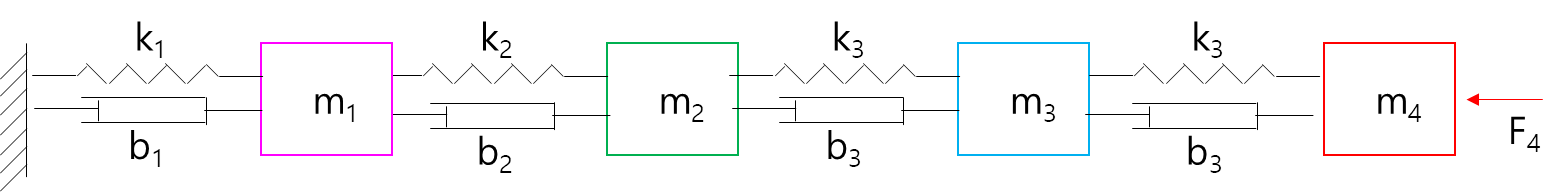

### Entradas

#### Degrau de Força de Entrada

In [91]:
# degrau de forca
def degrau_forca(t):
    if t <= 5.0:
        forca = forca_inicial
    else:
        forca = forca_final
    return forca

#### Campo Vetorial

In [92]:
len(range(2,2*n-2))

8

In [93]:
def degrau_forca_vectorfield(t, w, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    # print(t)
    # print(w)
    # print(p)
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    if n == 1:
        f.append( (-b * w[1] - k * (w[0] - L) + degrau_forca(t))/ m )
    elif n >= 2:
        f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
                # (-b * y1   + b * (y2   - y1)   - k * (x1   - L) + k * (x2     - x1    - L) ) / m,
        for i in range(2,2*n-2):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
        f.append( w[2*n-1] )
        f.append( (-b * (w[2*n-1] - w[2*n-3])  - k * (w[2*n-2] - w[2*n-4] - L) + degrau_forca(t)) / m )
    # y16,
    # (-b * (y16 - y15)  - k * (x16 - x15 - L) + degrau_forca(t)) / m,
    return f

### Saídas

#### Unpacking

In [94]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
w0 = xizesys

# Call the ODE solver.
# wsol = odeint(degrau_forca_vectorfield, w0, t, args=(p,),
#               atol=abserr, rtol=relerr)
wsol = solve_ivp(degrau_forca_vectorfield, (0.0, 25.0), w0, args=(p, ),
                 t_eval=t, atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
y = [list(i) for i in zip(*wsol.y)]
for t1, w1 in zip(wsol.t, y):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    for i in range(n):
        ax[i].append(w1[2*i])
        ay[i].append(w1[2*i+1])
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
        KE[i].append(m*w1[2*i+1]**2/2)
    ET.append(np.sum([k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2 if i == 0 else k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2 for i in range(n) ]))

#### Forças Aplicada e de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for 6-Discrete Spring-Mass System degrau forca')

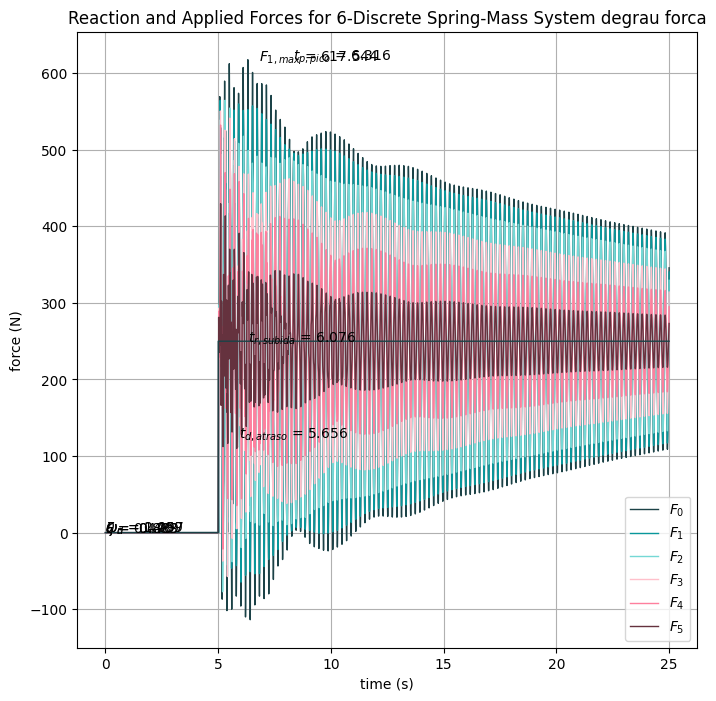

In [95]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ degrau_forca(t) for t in at ]), linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
# indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
# plt.text(
#     at[indice_ts],
#     F[0][indice_ts]-0.05,
#     '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
#     )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System degrau forca')

Text(0.5, 1.0, 'Reaction and Applied Forces for 6-Discrete Spring-Mass System degrau forca')

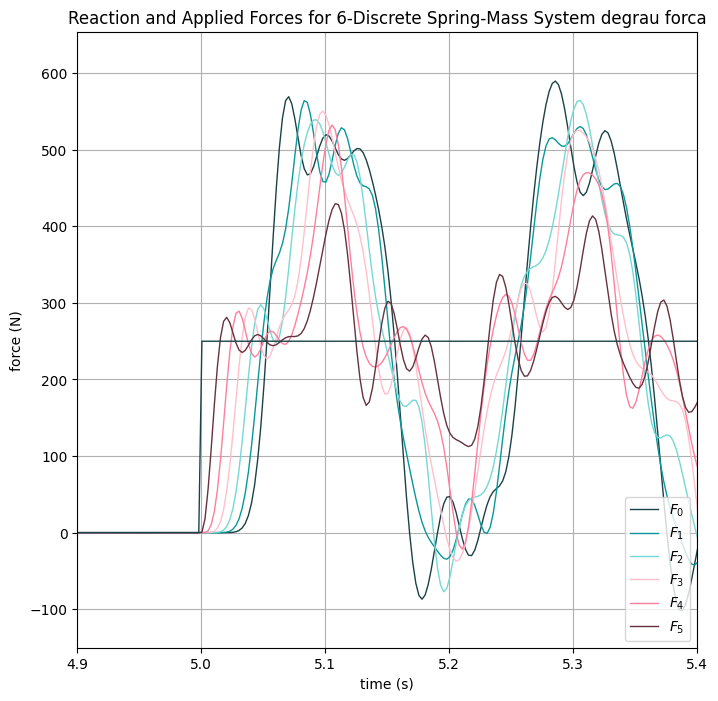

In [96]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ degrau_forca(t) for t in at ]), linewidth=1)
axis = plt.gca()
axis.set_xlim(4.9, 5.4)
# ax.set_ylim([ymin, ymax])
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System degrau forca')

Text(0.5, 1.0, 'Reaction and Applied Forces for 6-Discrete Spring-Mass System degrau forca')

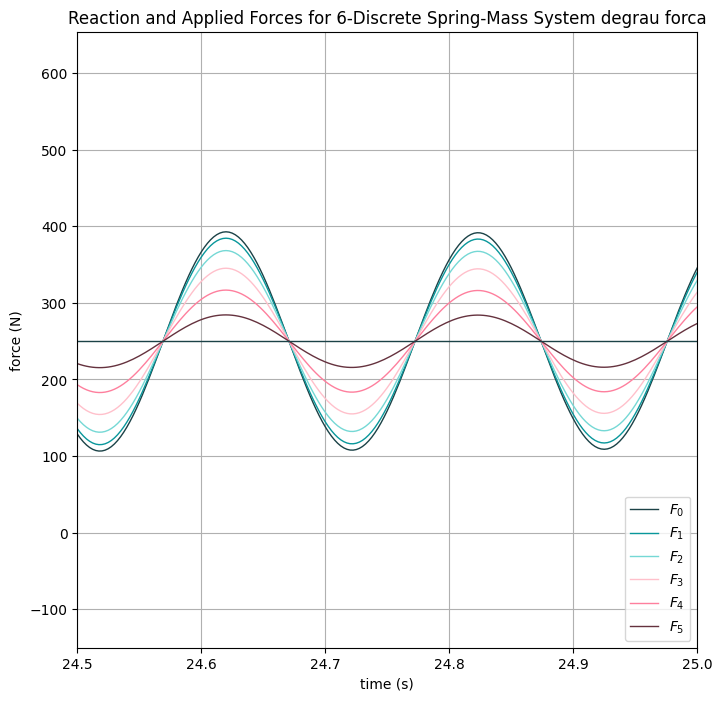

In [97]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ degrau_forca(t) for t in at ]), linewidth=1)
axis = plt.gca()
axis.set_xlim([24.5, 25])
# ax.set_ylim([ymin, ymax])
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System degrau forca')

In [98]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

In [99]:
forcas[forcas.index(max(forcas))]

617.5444295476191

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 6-Discrete Spring-Mass System degrau forca')

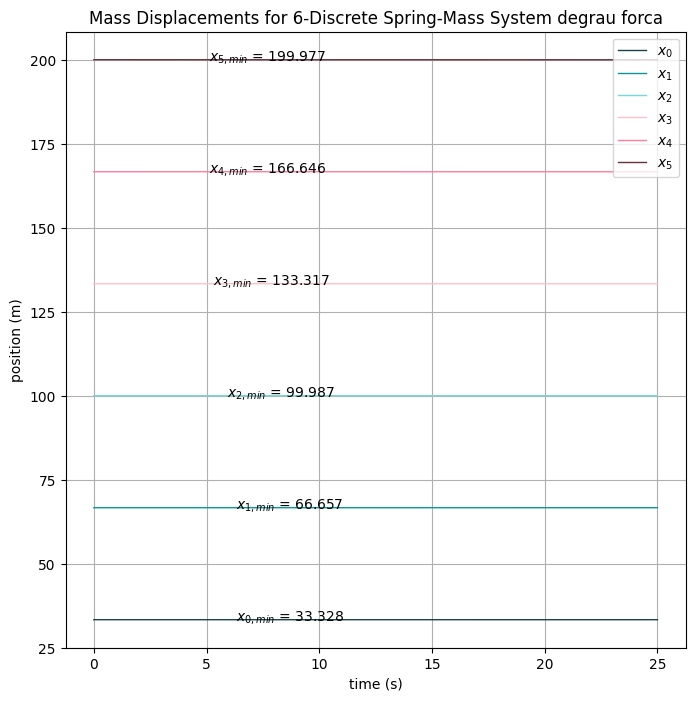

In [100]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x), '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 6-Discrete Spring-Mass System degrau forca')

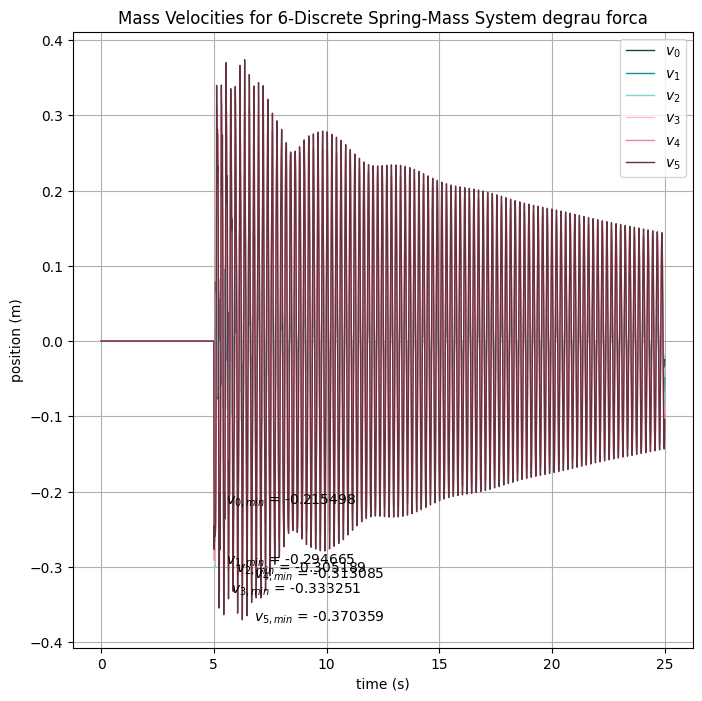

In [101]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.6f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Energias

Text(0.5, 1.0, 'Internal Energies for 6-Discrete Spring-Mass System degrau forca')

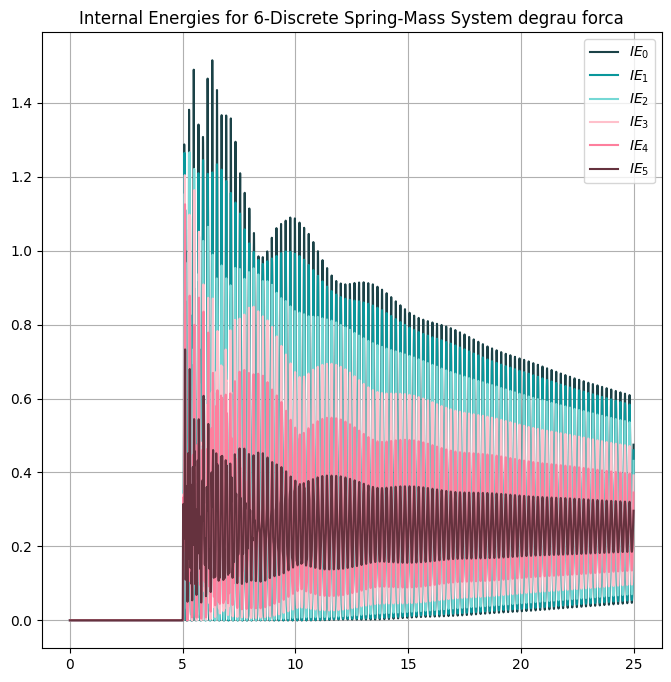

In [102]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for '+str(n)+'-Discrete Spring-Mass System degrau forca')

In [103]:
len(KE)

6

Text(0.5, 1.0, 'Kinetic Energies for 6-Discrete Spring-Mass System degrau forca')

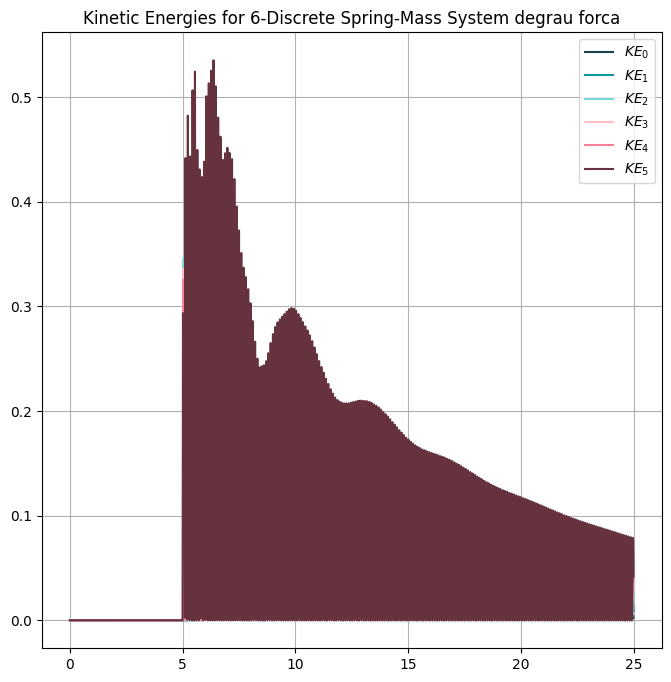

In [104]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System degrau forca')

Text(0.5, 1.0, 'Total Energy for 6-Discrete Spring-Mass System degrau forca')

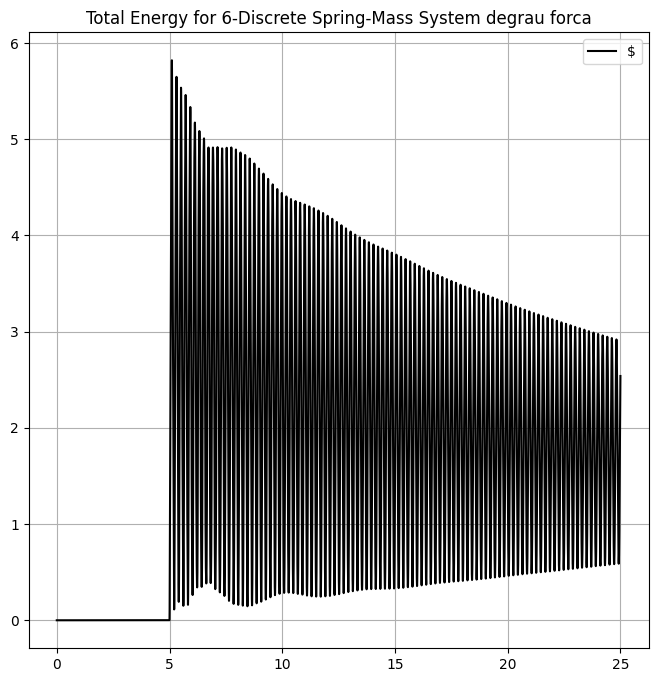

In [105]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend(r'$E_T$')
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Extremos

In [106]:
print(np.array(
    [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
))
print([
  EH.K2En(ax[i], m=4) for i in range(n)
])

[[ 0.02567312  0.00645363 -0.01463184 -0.06306926]
 [ 0.0201076   0.00338598 -0.01056114 -0.05604317]
 [ 0.02738445  0.00505297 -0.01336952 -0.06381462]
 [ 0.02176804  0.00031152 -0.01444479 -0.06516977]
 [ 0.02383723  0.00357592 -0.01141806 -0.05318196]
 [ 0.03343418  0.00424435 -0.0105964  -0.04407992]]
[(array([0.27413265, 0.26710778, 0.17296038, 0.1158875 ]), array([0.14172659, 0.10774498, 0.08248854, 0.06938696, 0.06179432])), (array([0.27737826, 0.25246634, 0.1697015 , 0.11015561]), array([0.14078474, 0.10668214, 0.08287947, 0.06994337, 0.06264791])), (array([0.26485948, 0.2496057 , 0.17575298, 0.1272348 ]), array([0.13861342, 0.10635999, 0.08286591, 0.06951001, 0.06120543])), (array([0.26295876, 0.2451237 , 0.16555898, 0.11647646]), array([0.13611517, 0.10464175, 0.08189344, 0.06939813, 0.06176788])), (array([0.26425629, 0.24556575, 0.17328651, 0.11509638]), array([0.13192239, 0.10128694, 0.07923291, 0.06662669, 0.05938305])), (array([0.25767111, 0.23994215, 0.18260099, 0.117427


## Entrada de Rampa em Força em $x_3$

### Entradas

#### Rampa de Força de Entrada

In [107]:
# rampa de forca
def rampa_forca(t):
    if t < tempo_inicial:
        forc = forca_inicial
    elif t >= tempo_inicial and t <= tempo_final:
        # forc = 5.0-1.0*t
        forc = forca_inicial+(forca_final-forca_inicial)/(10.0-5.0)*(t-5.0)
    else:
        forc = forca_final
    return forc

#### Campo Vetorial

In [108]:
def rampa_forca_vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
            # (-b * y1   + b * (y2   - y1)   - k * (x1   - L) + k * (x2     - x1    - L) ) / m,
    if n > 2:
        for i in range(2,2*n-2):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
    f.append( w[2*n-1] )
    f.append( (-b * (w[2*n-1] - w[2*n-3])  - k * (w[2*n-2] - w[2*n-4] - L) + rampa_forca(t)) / m )
    # y16,
    # (-b * (y16 - y15)  - k * (x16 - x15 - L) + degrau_forca(t)) / m,
    return f

### Saídas

#### Unpacking

In [109]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
# w0 = [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#       x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16]

w0 = xizesys

# Call the ODE solver.
wsol = odeint(rampa_forca_vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
for t1, w1 in zip(t, wsol):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    for i in range(n):
        ax[i].append(w1[2*i])
        ay[i].append(w1[2*i+1])
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
        KE[i].append(m*w1[2*i+1]**2/2)
    ET.append(np.sum([k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2 if i == 0 else k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2 for i in range(n) ]))

#### Forças Aplicadas e de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for n-Discrete Spring-Mass System rampa forca')

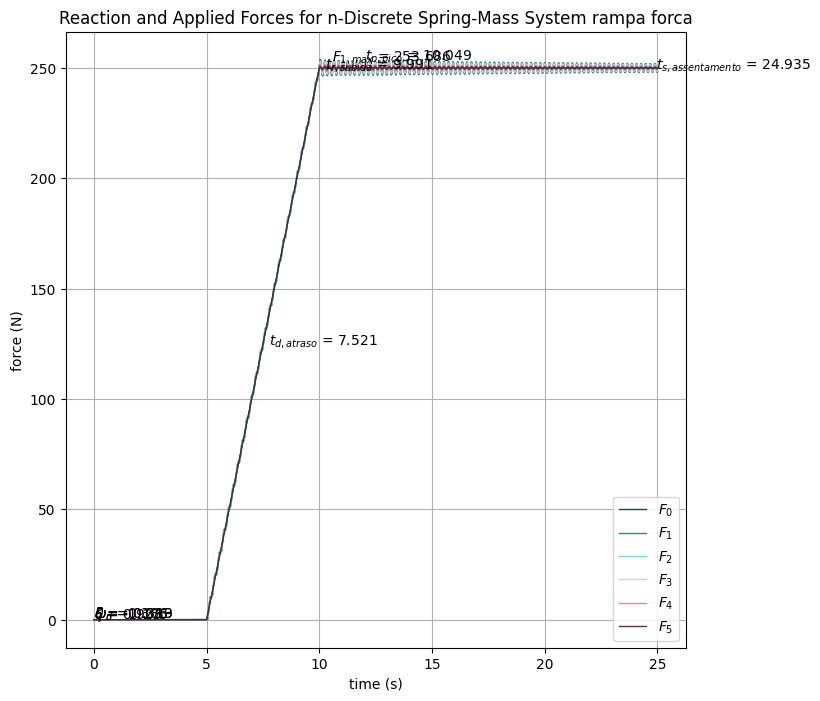

In [110]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ rampa_forca(t) for t in at ]), linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
plt.text(
    at[indice_ts],
    F[0][indice_ts]-0.05,
    '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
    )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for n-Discrete Spring-Mass System rampa forca')

In [111]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

In [112]:
forcas[forcas.index(max(forcas))]

253.68640141468495

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 6-Discrete Spring-Mass System rampa forca')

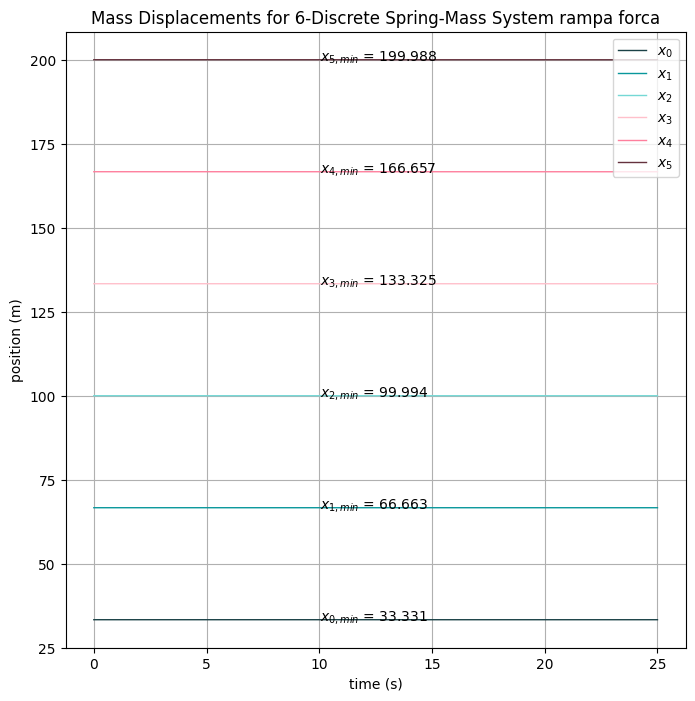

In [113]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x)-0.1, '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 6-Discrete Spring-Mass System rampa forca')

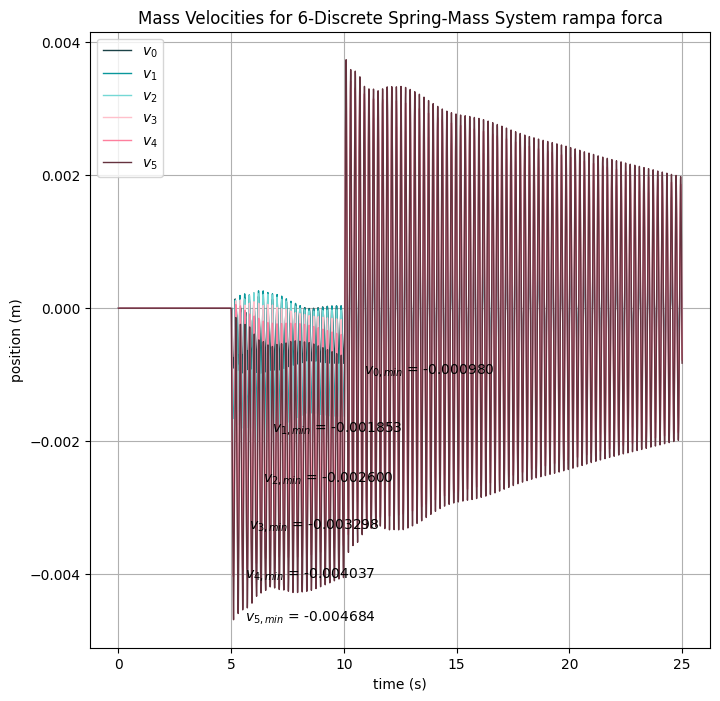

In [114]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.6f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Energias

Text(0.5, 1.0, 'Internal Energies for 6-Discrete Spring-Mass System rampa forca')

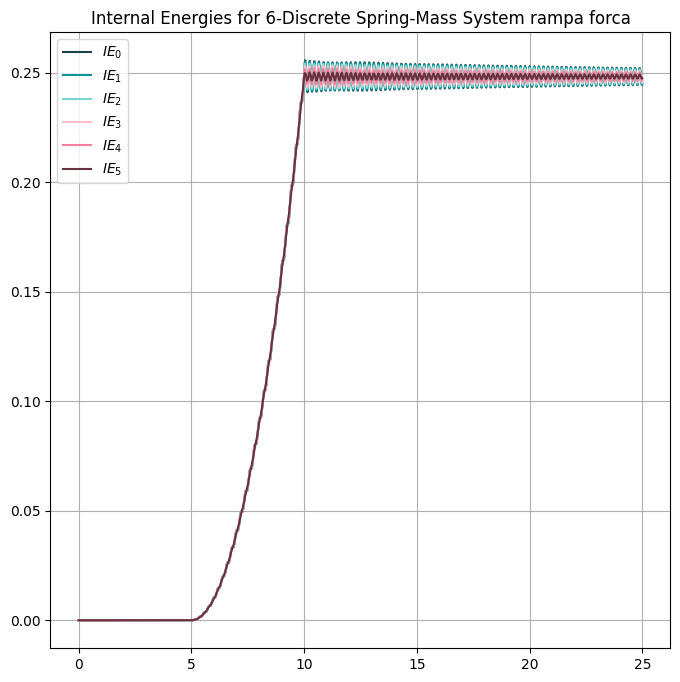

In [115]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for '+str(n)+'-Discrete Spring-Mass System rampa forca')

Text(0.5, 1.0, 'Kinetic Energies for 6-Discrete Spring-Mass System rampa forca')

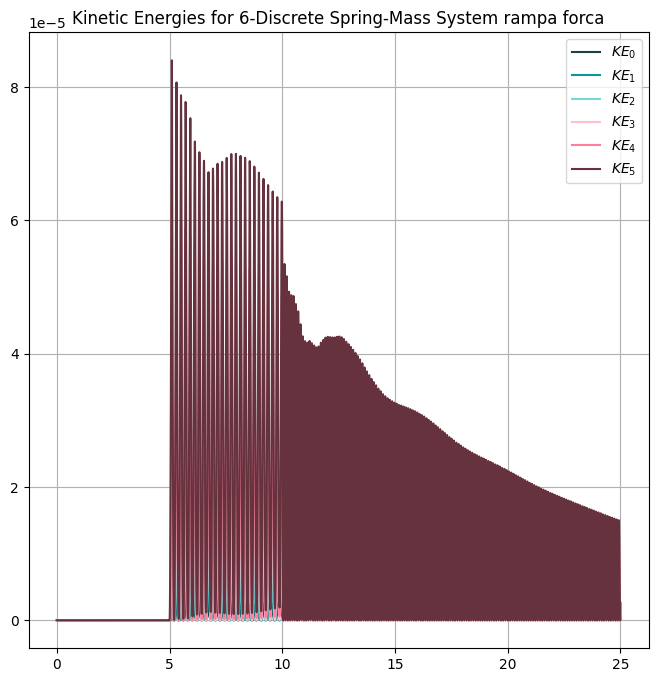

In [116]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System rampa forca')

Text(0.5, 1.0, 'Total Energy for 6-Discrete Spring-Mass System rampa forca')

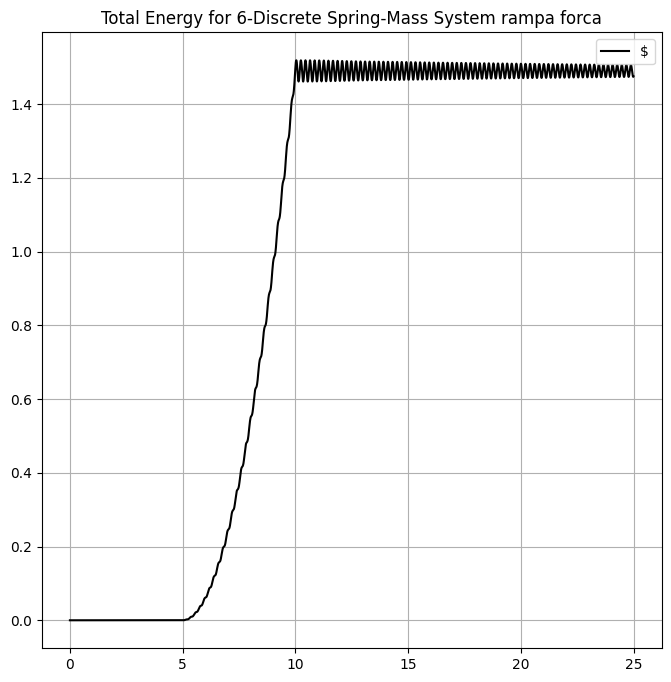

In [117]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend((r'$E_T$'))
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Extremos

In [118]:
print(np.array(
    [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
))
print(np.array([
  EH.K2En(ax[i], m=4) for i in range(n)
]))

[[ 0.02760814  0.00229282 -0.04181632 -0.1423418 ]
 [ 0.02409533  0.00394211 -0.03605488 -0.11906463]
 [ 0.02958799 -0.00252352 -0.04251744 -0.11016542]
 [ 0.01958643  0.0043918  -0.0379996  -0.10236096]
 [ 0.02196112  0.00049088 -0.0402085  -0.12096709]
 [ 0.07025136  0.00389291 -0.02217584 -0.0944934 ]]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (6, 2) + inhomogeneous part.

## Entrada de Rampa em Deslocamento em $x_3$

### Entradas

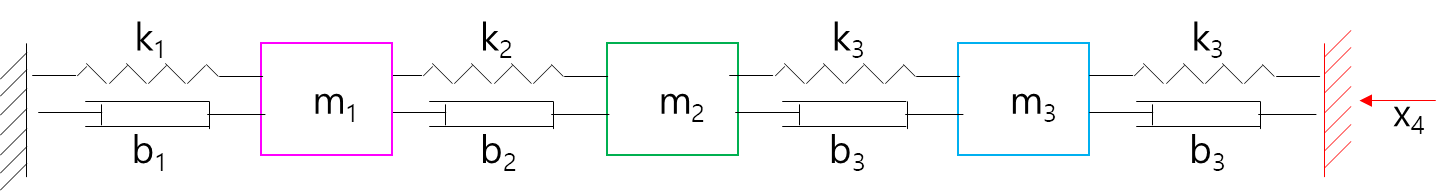

#### Rampa em Degrau de Entrada

In [ ]:
def rampa_disp(t):
    return rampa_forca(t)*(n/k)+(n*L)

Criando uma derivada da função rampa definida de forma simbólica.

In [ ]:
from sympy import Piecewise
from sympy import symbols

In [ ]:
tempo = symbols('t')
rampa_desl = Piecewise(
    (forca_inicial*(n/k)+(n*L), (tempo > 0.0) & (tempo < tempo_inicial)),
    (n/k*(forca_inicial+(forca_final-forca_inicial)/(tempo_final-tempo_inicial)*(tempo-tempo_inicial))+n*L, \
      (tempo >= tempo_inicial) & (tempo < tempo_final)),
    (forca_final*(n/k)+(n*L), (tempo >= tempo_final))
)
rampa_desl_derivada = rampa_desl.diff(tempo)
rampa_desl.diff(tempo)

In [ ]:
def deriv_desl(t):
     if t < tempo_inicial:
         dd = 0.0
     elif t >= tempo_inicial and t <= tempo_final:
         # forc = 5.0-1.0*t
         dd = n/k*(forca_inicial+(forca_final-forca_inicial)/(tempo_final-tempo_inicial))
     else:
         dd = 0.0
     return dd

In [ ]:
rampa_desl

In [ ]:
plt.plot([ rampa_disp(t) for t in np.linspace(0.0,20.0,100)])

In [ ]:
plt.plot([ deriv_desl(t) for t in np.linspace(0.0,20.0,100)])

#### Campo Vetorial

In [ ]:
def rampa_desl_vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    if n > 2:
        f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
    elif n==2:
        f.append( (-b * w[1] + b * (deriv_desl(t) - w[1]) - k * (w[0] - L) + k * (rampa_disp(t) - w[0] - L ) )/ m )
    if n > 2:
        for i in range(2,2*n-4):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
        f.append( w[2*n-3] )
        f.append( (-b * (w[2*n-3] - w[2*n-5]) + b * (deriv_desl(t) - w[2*n-3]) - k * (w[2*n-4] - w[2*n-6] - L) + k * (rampa_disp(t) - w[2*n-4] -L) ) / m )
    # y15,
    # (-b * (y15 - y14) + b * (deriv_desl(t) - y15) - k * (x15 - x14 - L) + k * (rampa_disp(t) - x15 - L) ) / m,
    return f

### Saídas

#### Unpacking

In [ ]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
w0 = xizesys_desl # [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
     #  x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15,] #  x16, y16]

# Call the ODE solver.
wsol = odeint(rampa_desl_vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
for t1, w1 in zip(t, wsol):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    ETt = 0.0
    for i in range(n):
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
            KE[i].append(m*w1[2*i+1]**2/2)
            ax[i].append(w1[2*i])
            ay[i].append(w1[2*i+1])
            ETt += k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2
        elif i==n-1:
            IE[i].append(k*(rampa_disp(t1)-w1[2*i-2]-L)**2/2)
            KE[i].append(m*deriv_desl(t1)**2/2)
            ax[i].append(rampa_disp(t1))
            ay[i].append(deriv_desl(t1))
            ETt += k*(rampa_disp(t1)-w1[2*i-2]-L)**2/2+m*deriv_desl(t1)**2/2
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
            KE[i].append(m*w1[2*i+1]**2/2)
            ax[i].append(w1[2*i])
            ay[i].append(w1[2*i+1])
            ETt += k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2
    ET.append(ETt)

#### Forças de Reação

In [ ]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
plt.text(
    at[indice_ts],
    F[0][indice_ts]-0.05,
    '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
    )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System rampa desl')

In [ ]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

#### Posições

In [ ]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x)-0.1, '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Velocidades

In [ ]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.6f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Energias

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for'+str(n)+'-Discrete Spring-Mass System rampa desl')

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System rampa desl')

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend(r'$E_T$')
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Extremos

In [ ]:
print(np.array(
    [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
))
print(np.array([
  EH.K2En(ax[i], m=4) for i in range(n)
]))